# Model Training (Posture Police)

# Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.18.0



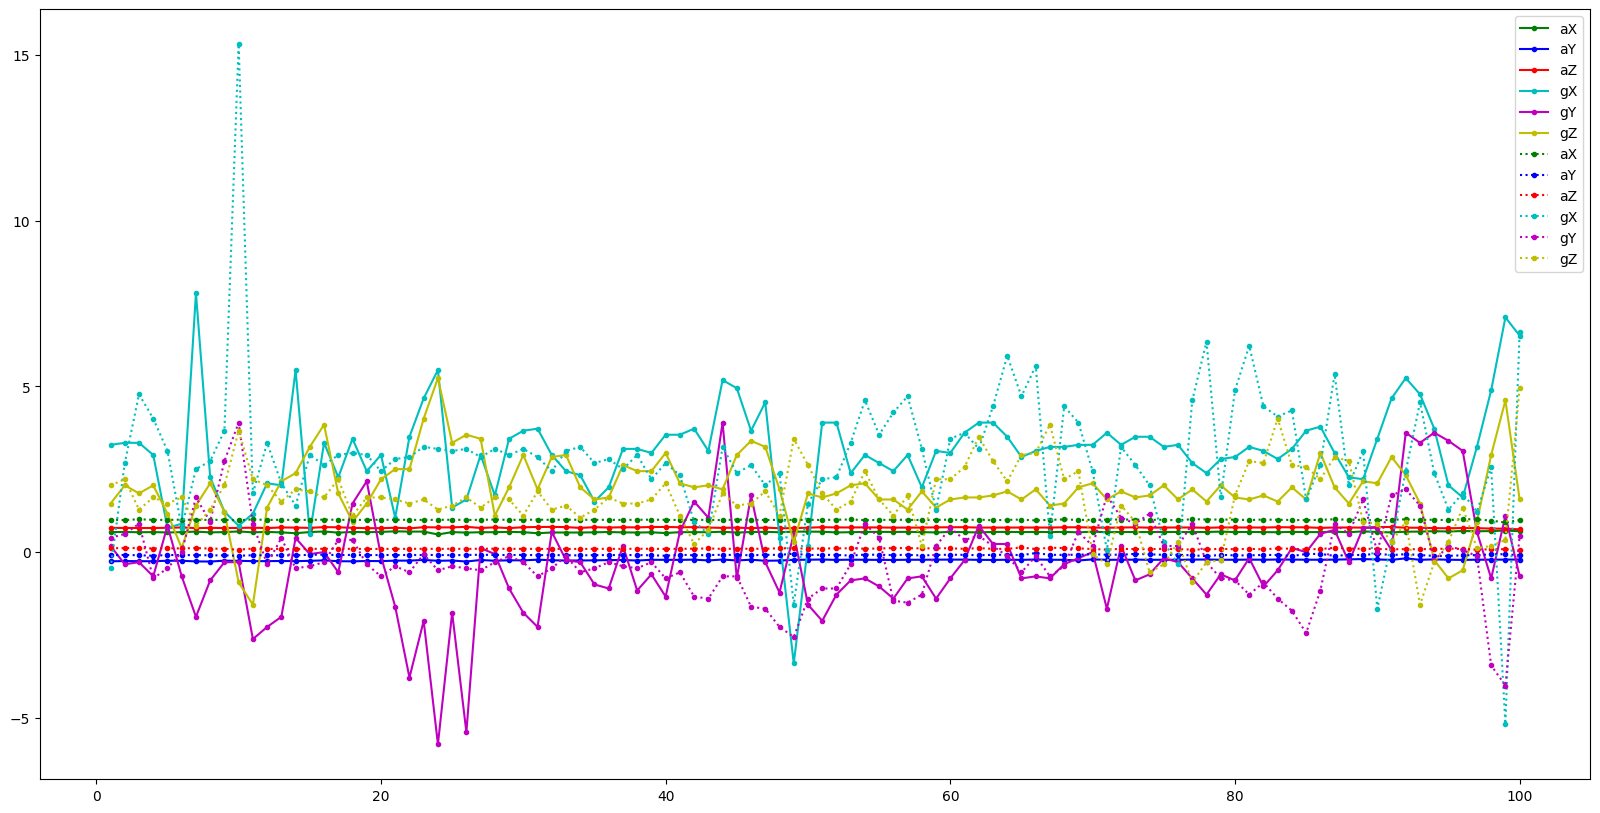

In [ ]:
def plot_ts(df, ax=None, ls='-'):
    num = 100  # Number of values to plot
    index = np.arange(1, len(df['aX']) + 1)

    # Plot accelerometer data
    ax.plot(index[:num], df['aX'].values[:num], 'g.', label='aX', linestyle=ls)
    ax.plot(index[:num], df['aY'].values[:num], 'b.', label='aY', linestyle=ls)
    ax.plot(index[:num], df['aZ'].values[:num], 'r.', label='aZ', linestyle=ls)

    # Plot gyroscope data
    ax.plot(index[:num], df['gX'].values[:num], 'c.', label='gX', linestyle=ls)
    ax.plot(index[:num], df['gY'].values[:num], 'm.', label='gY', linestyle=ls)
    ax.plot(index[:num], df['gZ'].values[:num], 'y.', label='gZ', linestyle=ls)


fig, ax = plt.subplots(figsize=(20, 10))

# Read the CSV files with additional columns
df_bad = pd.read_csv("/content/sample_data/bad.csv",
                     names=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'], delimiter=',')
plot_ts(df_bad, ax, ls='-')

df_good = pd.read_csv("/content/sample_data/good.csv",
                      names=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'], delimiter=',')
plot_ts(df_good, ax, ls=':')

plt.legend()
plt.show()

# Training

### Data loading

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# List of labels
POSTURES = ["bad", "good"]

SAMPLES_PER_POSTURE = 20
NUM_POSTURES = len(POSTURES)

inputs = []
outputs = []

# Read each CSV file and push an input and output
for posture_index in range(NUM_POSTURES):
    gesture = POSTURES[posture_index]
    print(f"Processing index {posture_index} for posture '{gesture}'.")

    # Read the CSV file with accelerometer and gyroscope data
    df = pd.read_csv(f"/content/sample_data/{gesture}.csv",
                     names=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'], delimiter=',')

    # Calculate the number of gesture recordings in the file
    num_recordings = int(df.shape[0] / SAMPLES_PER_POSTURE)

    for i in range(num_recordings):
        index = i * SAMPLES_PER_POSTURE

        # Extract accelerometer and gyroscope data
        X = df['aX'][index: index + SAMPLES_PER_POSTURE].values
        Y = df['aY'][index: index + SAMPLES_PER_POSTURE].values
        Z = df['aZ'][index: index + SAMPLES_PER_POSTURE].values
        gX = df['gX'][index: index + SAMPLES_PER_POSTURE].values
        gY = df['gY'][index: index + SAMPLES_PER_POSTURE].values
        gZ = df['gZ'][index: index + SAMPLES_PER_POSTURE].values

        # Stack all sensor data together
        tensor = np.vstack((X, Y, Z, gX, gY, gZ)).transpose()

        inputs.append(tensor)
        outputs.append(posture_index)

# Convert lists to numpy arrays
inputs = np.array(inputs)
outputs = np.array(outputs)

print(inputs.shape, outputs.shape)

Processing index 0 for gesture 'bad'.
Processing index 1 for gesture 'good'.
(600, 20, 6) (600,)


### Preparing data

In [ ]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(
    inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(
    outputs, [TRAIN_SPLIT, TEST_SPLIT])

Data set randomization and splitting complete. inputs_train.shape=(360, 20, 6), outputs_train.shape=(360,)


In [ ]:
print(inputs_train.dtype, outputs_train.dtype)
print(inputs_validate.dtype, outputs_validate.dtype)
print(inputs_train)  # Preview first few entries

float64 int64
float64 int64
[[[ 0.860718 -0.362793 -0.290039 -1.098633  3.540039  2.990723]
  [ 0.874512 -0.379517 -0.303589 -2.990723  0.427246  1.831055]
  [ 0.80835  -0.356934 -0.292725  0.976562  8.178711  2.075195]
  ...
  [ 0.867676 -0.366577 -0.375977  6.896973  0.12207   1.647949]
  [ 0.845215 -0.369629 -0.370361  3.78418  -2.441406  1.525879]
  [ 0.850586 -0.359253 -0.341309  3.173828 -2.746582  1.708984]]

 [[ 0.984375  0.047485  0.033203 -1.220703  0.061035  2.624512]
  [ 0.983765  0.062256  0.050659 -0.183105 -1.586914 -0.610352]
  [ 0.97168   0.048706  0.040649 -0.061035 -1.403809 -1.342773]
  ...
  [ 0.919678  0.023193 -0.06311   5.249023  5.310059  3.234863]
  [ 0.983154  0.058594 -0.071777  4.455566  5.737305  2.929688]
  [ 0.980713  0.05249  -0.068237  4.272461  7.93457   1.586914]]

 [[ 0.924316 -0.348145  0.038208  1.220703 -0.427246  1.89209 ]
  [ 0.924927 -0.354492  0.036011  0.549316 -0.12207   0.366211]
  [ 0.920654 -0.349976  0.040527 -0.488281 -0.793457  0.9155

In [ ]:
# Model
model = tf.keras.Sequential([
    tf.keras.Input(shape=inputs_train.shape[1:], name='input'),
    tf.keras.layers.GlobalMaxPool1D(
        data_format='channels_last', name='global_max_pooling1d'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_POSTURES, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ global_max_pooling1d                 │ (None, 6)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 290 (1.13 KB)

 Trainable params: 290 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x=inputs_train,
    y=outputs_train,
    validation_data=[inputs_validate, outputs_validate],
    batch_size=32,
    shuffle=True,
    epochs=20
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5369 - loss: 0.9141 - val_accuracy: 0.6750 - val_loss: 0.6024
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7015 - loss: 0.6783 - val_accuracy: 0.8667 - val_loss: 0.4744
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8524 - loss: 0.5638 - val_accuracy: 0.9167 - val_loss: 0.4218
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8648 - loss: 0.5016 - val_accuracy: 0.8750 - val_loss: 0.3900
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8611 - loss: 0.4632 - val_accuracy: 0.9083 - val_loss: 0.3460
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8772 - loss: 0.4170 - val_accuracy: 0.9583 - val_loss: 0.2976
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9142 - loss: 0.3702 - val_accuracy: 0.9750 - val_loss: 0.2646
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9254 - loss: 0.3382 - val_accuracy: 0.9750 - val_loss

## Plot training statistics

In [ ]:
def plot_train_val_statistics(training_statistics, validation_statistics, statistics_name='accuracy'):
    plt.figure(figsize=(8, 6))
    plt.plot(training_statistics)
    plt.plot(validation_statistics)
    plt.title(statistics_name)
    plt.ylabel(statistics_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

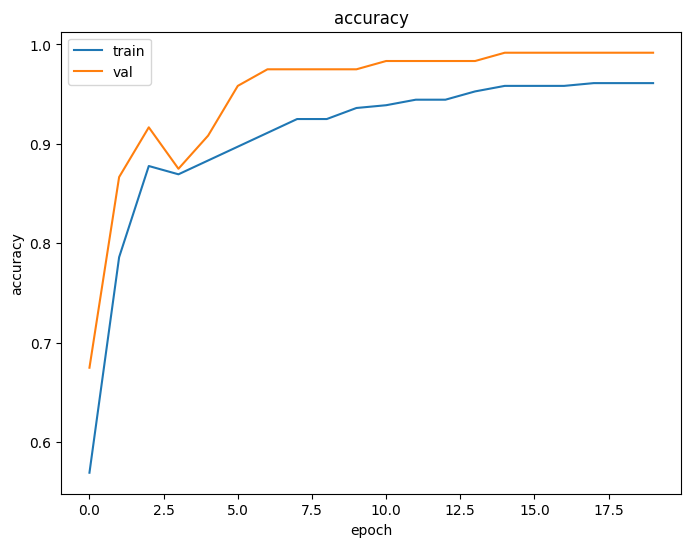

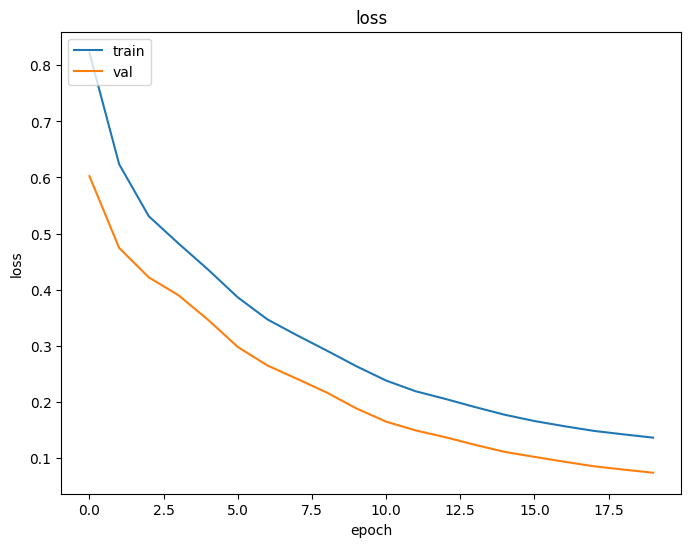

In [ ]:
plot_train_val_statistics(
    history.history['accuracy'], history.history['val_accuracy'], 'accuracy')
plot_train_val_statistics(
    history.history['loss'], history.history['val_loss'], 'loss')

In [ ]:
# Results on the test set
performance = model.evaluate(x=inputs_test, y=outputs_test)
print(''.join([f"{name}={value:.05f}  " for name,
      value in zip(model.metrics_names, performance)]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9744 - loss: 0.1526 
loss=0.14985  compile_metrics=0.97500  


## Confidence of the prediction

In [ ]:
from scipy.stats import entropy

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


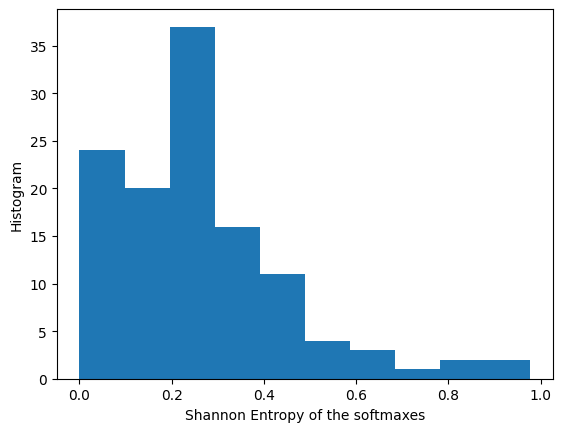

In [ ]:
pred = model.predict(inputs_test)
H = entropy(pred, base=2, axis=1)
plt.hist(H, bins=10)
plt.xlabel("Shannon Entropy of the softmaxes")
plt.ylabel("Histogram")
plt.show()

## Convert the Trained Model to Tensor Flow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model_quantized.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmpx_xnqx1d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 6), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132826561604368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132829321322256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132829321320336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132826597151888: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/tmp/tmplbogu8fy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 6), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132826561604368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132829321322256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132829321320336: TensorSpec(shape=()

3160

## Encode the Model in an Arduino Header File

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model_quantized.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 19,522 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
